# Setup

In [3]:
import numpy as np
import pandas as pd

# from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

In [7]:
# set path
processed_data_path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/'

# Battery

# App

A combination of active and passive (digital trace) data collected using the [myDataHelps](https://mydatahelps.org/) app

## Affect

### Load Data

In [105]:
df_affect = pd.read_csv(processed_data_path + 'run1_affect.csv')

In [106]:
profile = ProfileReport(df_affect.drop(['trial_date', 'ParticipantIdentifier'], axis=1),
                        title="Affect Measures: Profiling Report",
                        dataset = {
                            'author': 'Daniel J Wilson',
                        }
                       )
profile.to_file(processed_data_path + "run1_affect.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Clean Data

Just selecting people that had at least a 50% response rate (i.e. 42 days)

In [33]:
good_subjects = pd.DataFrame(df_affect.groupby('ParticipantIdentifier')['trial_date'].count()).reset_index()

In [19]:
good_subjects = list(good_subjects.loc[good_subjects.trial_date>=42].ParticipantIdentifier)
print(f'There are {len(good_subjects)} subjects with more than 50% adherence')

There are 44 subjects with more than 50% adherence


In [20]:
df_affect_clean = df_affect.loc[df_affect.ParticipantIdentifier.isin(good_subjects)]

In [21]:
df_affect.shape

(4076, 42)

In [22]:
df_affect_clean.shape

(3180, 42)

In [23]:
# for ease of typing...can rerun if we lose this variable
df = df_affect_clean.copy()

# just looking at pm report for now
df_pm = df.loc[:, ~df.columns.str.endswith('_am')]

### Correlations

Remember this is just for **PM** ratings

Morning ratings were not required and expired at noon, so it was common for people to miss doing these...

#### Overall

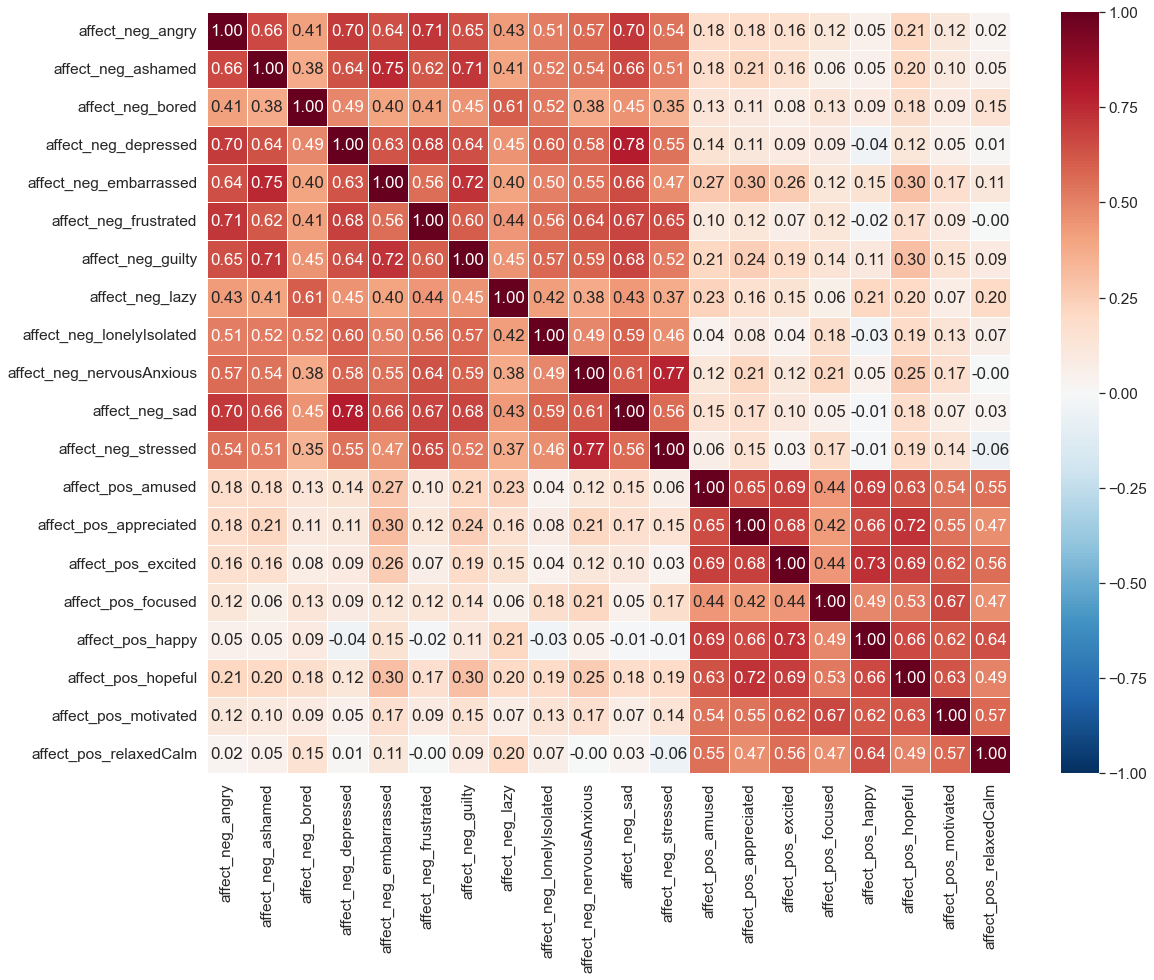

In [26]:
sns.set(rc={'figure.figsize':(18,14)})
sns.set(font_scale=1.4)

dfp = df.drop(['trial_date', 'ParticipantIdentifier'], axis=1)

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Largest Values

In [27]:
x = pd.DataFrame(dfp.corr().unstack().sort_values()).reset_index()

x.rename(columns={'level_0': 'affect1',
                  'level_1': 'affect2',
                  0: 'cor'
                  }, inplace=True)

In [28]:
# top -ve correlations
x.loc[x.cor < -.2].drop_duplicates(subset=['cor']).reset_index(drop=True)

,affect1,affect2,cor


In [29]:
# top +ve correlations
x.loc[x.cor > .5].drop_duplicates(subset=['cor']).sort_values(by = 'cor', ascending=False).reset_index(drop=True)[1:11]

,affect1,affect2,cor
1,affect_neg_depressed,affect_neg_sad,0.782420
2,affect_neg_nervousAnxious,affect_neg_stressed,0.771265
3,affect_neg_ashamed,affect_neg_embarrassed,0.750291
4,affect_pos_happy,affect_pos_excited,0.727604
5,affect_neg_embarrassed,affect_neg_guilty,0.723848
6,affect_pos_appreciated,affect_pos_hopeful,0.722174
7,affect_neg_frustrated,affect_neg_angry,0.713534
8,affect_neg_ashamed,affect_neg_guilty,0.711948
9,affect_neg_angry,affect_neg_sad,0.703445
10,affect_neg_depressed,affect_neg_angry,0.696228


#### Within Subject correlations

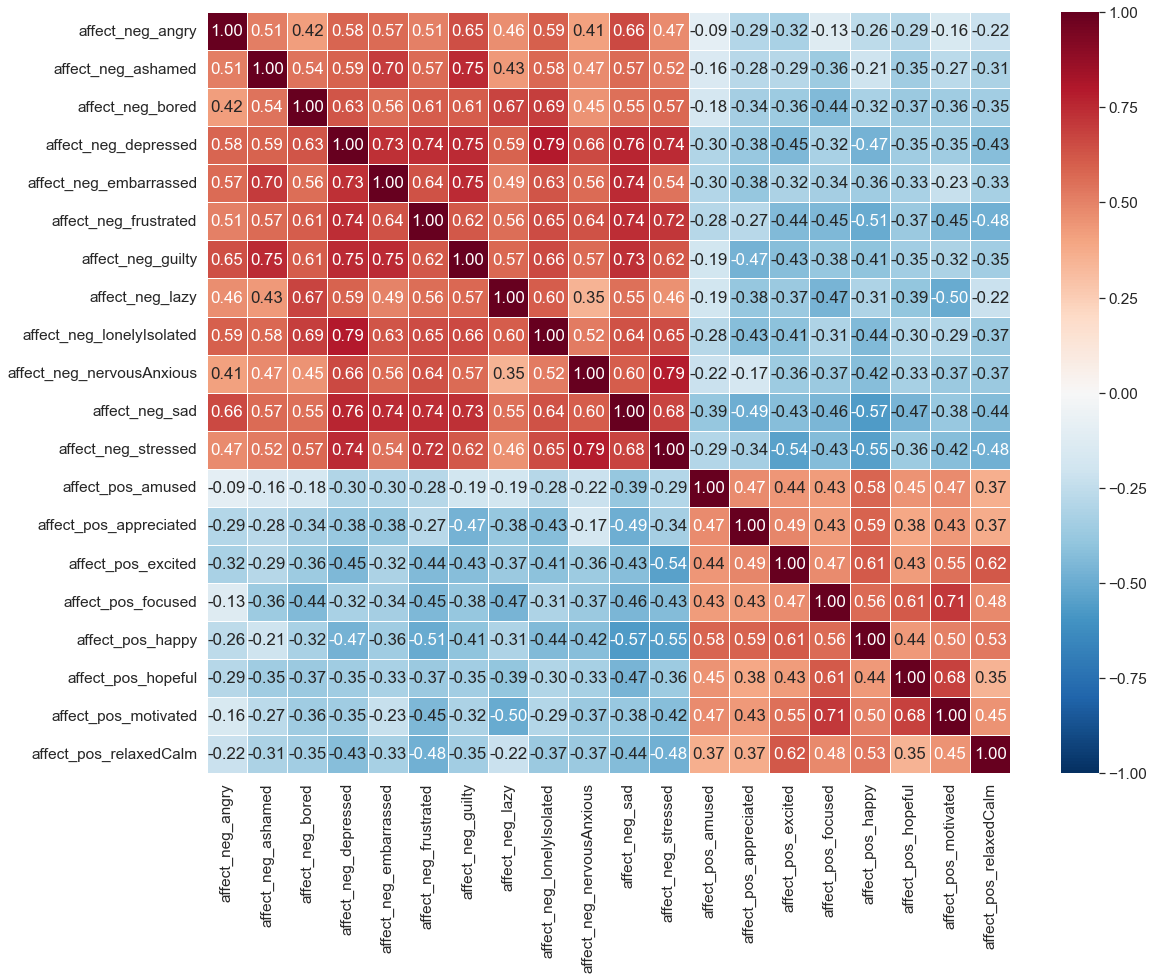

In [32]:
subs = np.unique(df.ParticipantIdentifier)
# select subject
# 5 very mixed
sub = 2 

x = df.loc[df.ParticipantIdentifier == subs[sub]]

dfp = x.drop(['trial_date', 'ParticipantIdentifier'], axis=1)

pvals = planets.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*planets.corr().shape)


sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Within Feature (lags)

Look at the autocorrelation with different time lags of individual affect measures

**NOTE**
> Need to impute data for missing days for this to work correctly for all subjects

> Right now just using subjects **with no missing days**

In [36]:
# get subjects with no missed days
subs = pd.DataFrame(df.groupby(['ParticipantIdentifier'])['trial_date'].count()).reset_index()
subs = subs.loc[subs.trial_date >= 82].reset_index(drop=True).ParticipantIdentifier

lag = df[df.ParticipantIdentifier.isin(subs)].reset_index(drop=True)
lag = lag.set_index('trial_date')

##### Between Subject

Change the `lags` variable to see the correlation over the span of multiple days...

In [41]:
lags = 2
lag.groupby('ParticipantIdentifier').agg(lambda x: x.autocorr(lag=lags)).mean().sort_values(ascending=False)

affect_neg_guilty            0.183289
affect_neg_stressed          0.149580
affect_neg_embarrassed       0.147886
affect_pos_motivated         0.139939
affect_neg_sad               0.129177
affect_pos_excited           0.124308
affect_pos_hopeful           0.123882
affect_neg_lazy              0.121232
affect_neg_depressed         0.117548
affect_neg_ashamed           0.109999
affect_pos_happy             0.103927
affect_pos_relaxedCalm       0.097584
affect_neg_lonelyIsolated    0.096526
affect_neg_frustrated        0.092199
affect_pos_amused            0.087390
affect_pos_appreciated       0.084036
affect_neg_nervousAnxious    0.083780
affect_pos_focused           0.079384
affect_neg_angry             0.070334
affect_neg_bored             0.064264
dtype: float64

##### Within Subject

Change the `lags` variable to see the correlation over the span of multiple days...

Change the `sub` varable to look at different subjects

In [48]:
lags = 2
sub = 3
lag.loc[lag.ParticipantIdentifier==subs[sub]].groupby('ParticipantIdentifier').agg(lambda x: x.autocorr(lag=lags)).iloc[0].sort_values(ascending=False)

affect_pos_relaxedCalm       0.347426
affect_pos_focused           0.344565
affect_neg_lazy              0.332736
affect_pos_excited           0.326015
affect_pos_motivated         0.294743
affect_neg_embarrassed       0.285714
affect_pos_happy             0.266414
affect_pos_hopeful           0.203117
affect_neg_depressed         0.189100
affect_neg_stressed          0.172866
affect_neg_nervousAnxious    0.168785
affect_neg_lonelyIsolated    0.129080
affect_neg_bored             0.103182
affect_neg_angry             0.094552
affect_neg_sad               0.088580
affect_neg_frustrated        0.065834
affect_pos_appreciated       0.035729
affect_neg_guilty           -0.007728
affect_neg_ashamed          -0.062500
affect_pos_amused           -0.166369
Name: 412330b3-cc02-4030-96cd-f4cfdcc45fa6, dtype: float64

## Daily Self Report Items

In [163]:
df_sr = pd.read_csv(processed_data_path + 'run1_selfReport.csv')

In [165]:
list(df_sr.columns)

['ParticipantIdentifier',
 'trial_date',
 'DAILY_goal1_confidence',
 'DAILY_goal1_consequences',
 'DAILY_goal1_effort',
 'DAILY_goal1_importance',
 'DAILY_goal1_interaction_month',
 'DAILY_goal1_interaction_week',
 'DAILY_goal1_motivationExternal',
 'DAILY_goal1_motivationInternal',
 'DAILY_goal1_report',
 'DAILY_goal2_confidence',
 'DAILY_goal2_consequences',
 'DAILY_goal2_effort',
 'DAILY_goal2_importance',
 'DAILY_goal2_interaction_eachOther',
 'DAILY_goal2_interaction_month',
 'DAILY_goal2_interaction_week',
 'DAILY_goal2_motivationExternal',
 'DAILY_goal2_motivationInternal',
 'DAILY_goal2_report',
 'DAILY_next24_drinks',
 'DAILY_next24_exercise',
 'DAILY_next24_leisureNonSolo',
 'DAILY_next24_leisureSolo',
 'DAILY_next24_nonoccupation',
 'DAILY_next24_occupation',
 'DAILY_next24_sleep',
 'DAILY_next24_socialMedia',
 'DAILY_past24_change',
 'DAILY_past24_diet',
 'DAILY_past24_drinks',
 'DAILY_past24_exercise',
 'DAILY_past24_fatigue',
 'DAILY_past24_gap',
 'DAILY_past24_gapCause',

In [ ]:
ParticipantIdentifier
trial_date
DAILY_goal1_confidence
DAILY_goal1_consequences
DAILY_goal1_effort
DAILY_goal1_importance
DAILY_goal1_interaction_month
DAILY_goal1_interaction_week
DAILY_goal1_motivationExternal
DAILY_goal1_motivationInternal
DAILY_goal1_report
DAILY_goal2_confidence
DAILY_goal2_consequences
DAILY_goal2_effort
DAILY_goal2_importance
DAILY_goal2_interaction_eachOther
DAILY_goal2_interaction_month
DAILY_goal2_interaction_week
DAILY_goal2_motivationExternal
DAILY_goal2_motivationInternal
DAILY_goal2_report
DAILY_next24_drinks
DAILY_next24_exercise
DAILY_next24_leisureNonSolo
DAILY_next24_leisureSolo
DAILY_next24_nonoccupation
DAILY_next24_occupation
DAILY_next24_sleep
DAILY_next24_socialMedia
DAILY_past24_change
DAILY_past24_diet
DAILY_past24_drinks
DAILY_past24_exercise
DAILY_past24_fatigue
DAILY_past24_gap
DAILY_past24_gapCause
DAILY_past24_ideal
DAILY_past24_illness
DAILY_past24_leisureNonSolo
DAILY_past24_leisureNonSoloMental
DAILY_past24_leisureNonSoloPhysical
DAILY_past24_leisureSolo
DAILY_past24_leisureSoloMental
DAILY_past24_leisureSoloPhysical
DAILY_past24_mentalEffort
DAILY_past24_nonoccupation
DAILY_past24_occupation
DAILY_past24_physicalEffort
DAILY_past24_procrastination
DAILY_past24_productivity
DAILY_past24_punctuality
DAILY_past24_satisfaction
DAILY_past24_sleep
DAILY_past24_socialMedia
DAILY_past24_unusualEvents
DAILY_past24_values
DAILY_past48to24_gap
DAILY_past48to24_gapCause
DAILY_survey_missed
DAILY_survey_situation1_surveys
DAILY_survey_situation2_surveys
DAILY_past24_gapCause_internal
DAILY_past24_gapCause_external
DAILY_gap_sleep
DAILY_gap_occupation
DAILY_gap_nonoccupation
DAILY_gap_leisureSolo
DAILY_gap_leisureNonSolo
DAILY_gap_exercise
DAILY_gap_socialMedia
DAILY_gap_drinks

In [74]:
# note that some columns could use additional pre-processing
## internal/internal gap cause
## DAILY_past48to24_gap
## missing unusual events?

In [108]:
profile = ProfileReport(df_sr.drop(['trial_date', 'ParticipantIdentifier'], axis=1),
                        title="Self Report Measures: Profiling Report",
                        dataset = {
                            'author': 'Daniel J Wilson',
                        }
                       )                       
profile.to_file(processed_data_path + "run1_selfReport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Clean Data

Just selecting people that had at least a 50% response rate (i.e. 42 days)

In [88]:
good_subjects = pd.DataFrame(df_sr.groupby('ParticipantIdentifier')['trial_date'].count()).reset_index()

In [89]:
good_subjects = list(good_subjects.loc[good_subjects.trial_date>=42].ParticipantIdentifier)
print(f'There are {len(good_subjects)} subjects with more than 50% adherence')

There are 44 subjects with more than 50% adherence


In [90]:
df_sr_clean = df_sr.loc[df_sr.ParticipantIdentifier.isin(good_subjects)]

In [91]:
df_sr.shape

(4114, 71)

In [92]:
df_sr_clean.shape

(3198, 71)

In [93]:
# for ease of typing...can rerun if we lose this variable
df = df_sr_clean.copy()

### Correlations

In [111]:
id_cols = ['ParticipantIdentifier', 
           'trial_date',
          ]

past24_general_numeric = [
    'DAILY_past24_gapCause_internal',
    'DAILY_past24_gapCause_external',
    'DAILY_past24_ideal',
    'DAILY_past24_satisfaction',
    'DAILY_past24_change',
    'DAILY_past24_productivity',
    'DAILY_past24_procrastination',
    'DAILY_past24_punctuality',
    'DAILY_past24_mentalEffort',
    'DAILY_past24_physicalEffort',
    'DAILY_past24_values',
    'DAILY_past24_gap',
    'DAILY_past24_illness',
    'DAILY_past24_fatigue',
    'DAILY_past24_unusualEvents'
]

past24_categories = [
    'DAILY_past24_sleep',
    'DAILY_past24_occupation',
    'DAILY_past24_nonoccupation',
    'DAILY_past24_exercise',
    'DAILY_past24_leisureSolo',
    'DAILY_past24_leisureSoloMental',
    'DAILY_past24_leisureSoloPhysical',
    'DAILY_past24_leisureNonSolo',
    'DAILY_past24_leisureNonSoloMental',
    'DAILY_past24_leisureNonSoloPhysical',
    'DAILY_past24_diet',
    'DAILY_past24_socialMedia',
    'DAILY_past24_drinks'
]

next24_categories = [
    'DAILY_next24_sleep',
    'DAILY_next24_occupation',
    'DAILY_next24_nonoccupation',
    'DAILY_next24_leisureSolo',
    'DAILY_next24_leisureNonSolo',
    'DAILY_next24_exercise',
    'DAILY_next24_socialMedia',
    'DAILY_next24_drinks',
    'DAILY_next24_diet'
]

specific_goals = [
    'DAILY_goal1_report',
    'DAILY_goal1_importance',
    'DAILY_goal1_consequences',
    'DAILY_goal1_motivationInternal',
    'DAILY_goal1_motivationExternal',
    'DAILY_goal1_confidence',
    'DAILY_goal1_effort',
    'DAILY_goal1_interaction_week',
    'DAILY_goal1_interaction_month',
    'DAILY_goal2_report',
    'DAILY_goal2_importance',
    'DAILY_goal2_consequences',
    'DAILY_goal2_motivationInternal',
    'DAILY_goal2_motivationExternal',
    'DAILY_goal2_confidence',
    'DAILY_goal2_effort',
    'DAILY_goal2_interaction_week',
    'DAILY_goal2_interaction_month',
    'DAILY_goal2_interaction_eachOther'
]

non_numeric_cols = [
    'DAILY_next24_diet',
    'DAILY_past48to24_gapCause',
    'DAILY_survey_situation1_surveys',
    'DAILY_survey_situation2_surveys',
    'DAILY_survey_missed',
    'DAILY_past24_gapCause'
]

#### Overall

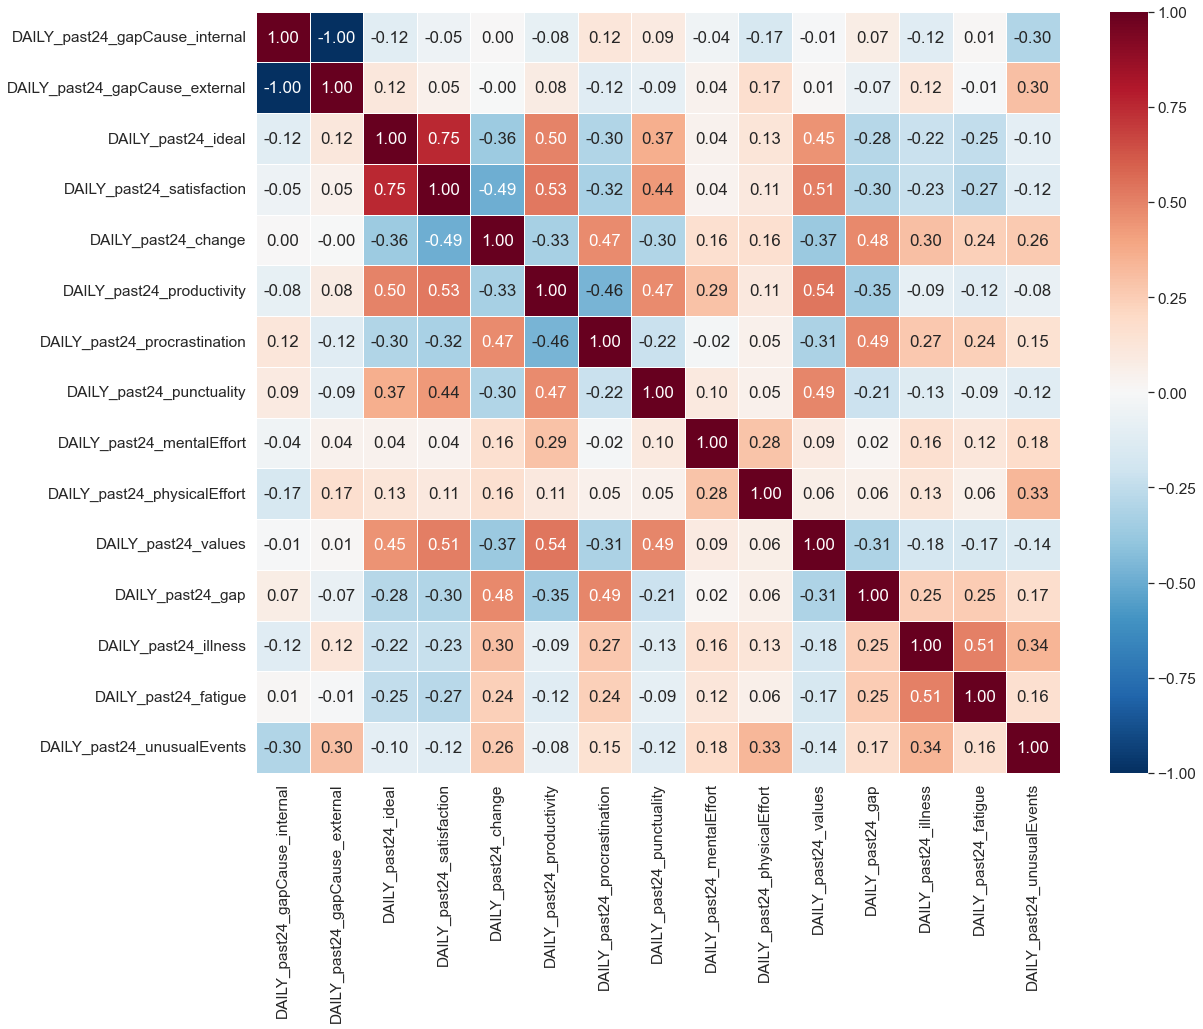

In [112]:
sns.set(rc={'figure.figsize':(18,14)})
sns.set(font_scale=1.4)

# select which columns to look at (can add columns)
dfp = df[past24_general_numeric]

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Largest Values

In [113]:
x = pd.DataFrame(dfp.corr().unstack().sort_values()).reset_index()

x.rename(columns={'level_0': 'self report 1',
                  'level_1': 'self report 2',
                  0: 'cor'
                  }, inplace=True)

In [114]:
# top -ve correlations
x.loc[x.cor < -.2].drop_duplicates(subset=['cor']).reset_index(drop=True)[1:11]

,self report 1,self report 2,cor
1,DAILY_past24_change,DAILY_past24_satisfaction,-0.488540
2,DAILY_past24_productivity,DAILY_past24_procrastination,-0.464802
3,DAILY_past24_values,DAILY_past24_change,-0.373968
4,DAILY_past24_ideal,DAILY_past24_change,-0.364343
5,DAILY_past24_gap,DAILY_past24_productivity,-0.345394
6,DAILY_past24_change,DAILY_past24_productivity,-0.330589
7,DAILY_past24_satisfaction,DAILY_past24_procrastination,-0.321172
8,DAILY_past24_values,DAILY_past24_procrastination,-0.314657
9,DAILY_past24_gap,DAILY_past24_values,-0.306908
10,DAILY_past24_change,DAILY_past24_punctuality,-0.302527


In [115]:
# top +ve correlations
x.loc[x.cor > .2].drop_duplicates(subset=['cor']).sort_values(by = 'cor', ascending=False).reset_index(drop=True)[1:11]

,self report 1,self report 2,cor
1,DAILY_past24_satisfaction,DAILY_past24_ideal,0.753723
2,DAILY_past24_values,DAILY_past24_productivity,0.536917
3,DAILY_past24_productivity,DAILY_past24_satisfaction,0.525544
4,DAILY_past24_satisfaction,DAILY_past24_values,0.508112
5,DAILY_past24_fatigue,DAILY_past24_illness,0.507071
6,DAILY_past24_productivity,DAILY_past24_ideal,0.497144
7,DAILY_past24_values,DAILY_past24_punctuality,0.492001
8,DAILY_past24_procrastination,DAILY_past24_gap,0.491100
9,DAILY_past24_change,DAILY_past24_gap,0.478066
10,DAILY_past24_punctuality,DAILY_past24_productivity,0.472521


#### Within Subject correlations

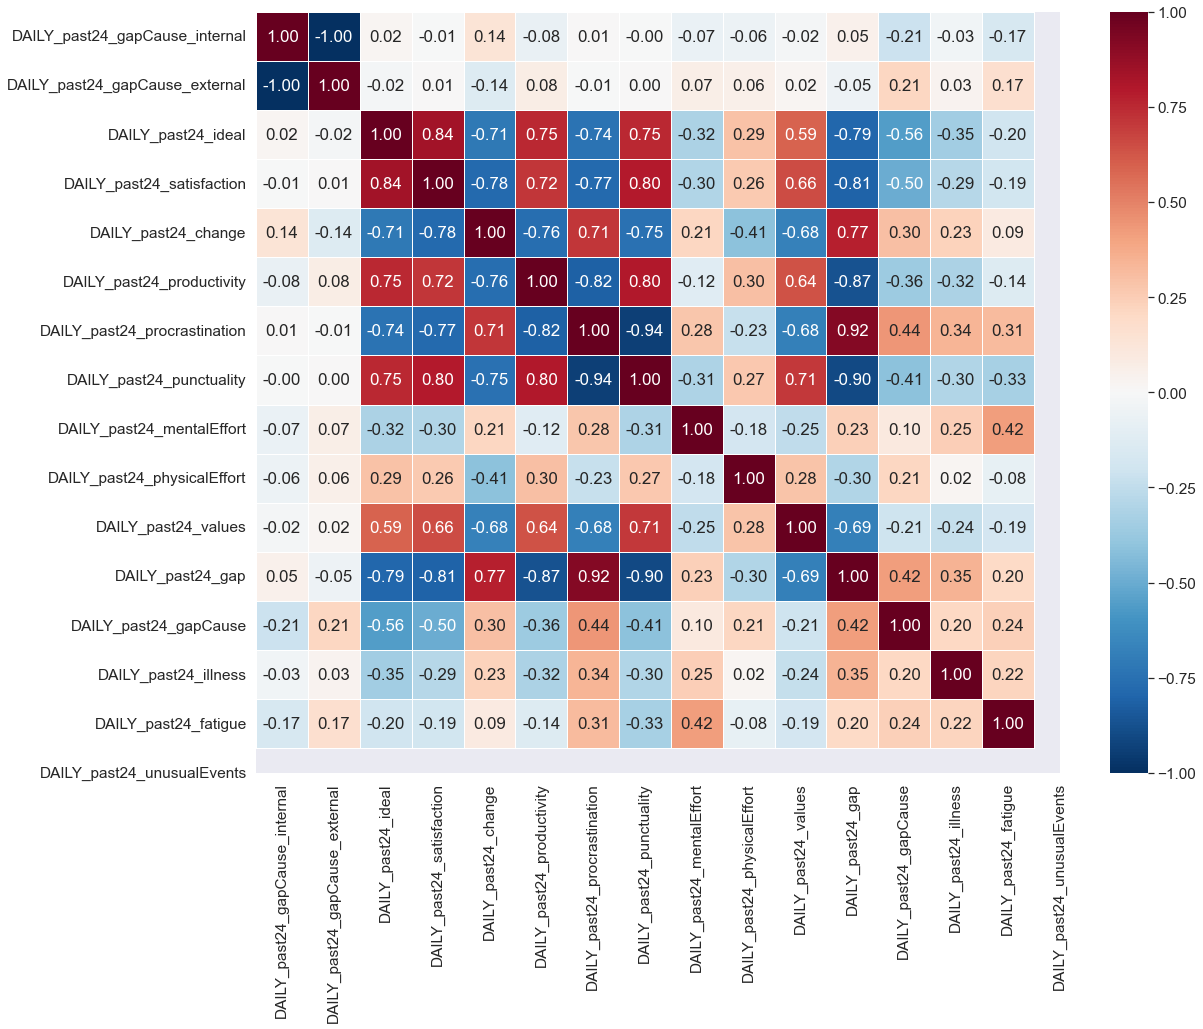

In [104]:
subs = np.unique(df.ParticipantIdentifier)
# select subject
# 5 very mixed
sub = 2 

x = df.loc[df.ParticipantIdentifier == subs[sub]]

dfp = x[past24_general_numeric]

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Within Feature (lags)

Look at the autocorrelation with different time lags of individual affect measures

**NOTE**
> Need to impute data for missing days for this to work correctly for all subjects

> Right now just using subjects **with no missing days**

In [36]:
# get subjects with no missed days
subs = pd.DataFrame(df.groupby(['ParticipantIdentifier'])['trial_date'].count()).reset_index()
subs = subs.loc[subs.trial_date >= 82].reset_index(drop=True).ParticipantIdentifier

lag = df[df.ParticipantIdentifier.isin(subs)].reset_index(drop=True)
lag = lag.set_index('trial_date')

##### Between Subject

Change the `lags` variable to see the correlation over the span of multiple days...

In [41]:
lags = 2
lag.groupby('ParticipantIdentifier').agg(lambda x: x.autocorr(lag=lags)).mean().sort_values(ascending=False)

affect_neg_guilty            0.183289
affect_neg_stressed          0.149580
affect_neg_embarrassed       0.147886
affect_pos_motivated         0.139939
affect_neg_sad               0.129177
affect_pos_excited           0.124308
affect_pos_hopeful           0.123882
affect_neg_lazy              0.121232
affect_neg_depressed         0.117548
affect_neg_ashamed           0.109999
affect_pos_happy             0.103927
affect_pos_relaxedCalm       0.097584
affect_neg_lonelyIsolated    0.096526
affect_neg_frustrated        0.092199
affect_pos_amused            0.087390
affect_pos_appreciated       0.084036
affect_neg_nervousAnxious    0.083780
affect_pos_focused           0.079384
affect_neg_angry             0.070334
affect_neg_bored             0.064264
dtype: float64

##### Within Subject

Change the `lags` variable to see the correlation over the span of multiple days...

Change the `sub` varable to look at different subjects

In [48]:
lags = 2
sub = 3
lag.loc[lag.ParticipantIdentifier==subs[sub]].groupby('ParticipantIdentifier').agg(lambda x: x.autocorr(lag=lags)).iloc[0].sort_values(ascending=False)

affect_pos_relaxedCalm       0.347426
affect_pos_focused           0.344565
affect_neg_lazy              0.332736
affect_pos_excited           0.326015
affect_pos_motivated         0.294743
affect_neg_embarrassed       0.285714
affect_pos_happy             0.266414
affect_pos_hopeful           0.203117
affect_neg_depressed         0.189100
affect_neg_stressed          0.172866
affect_neg_nervousAnxious    0.168785
affect_neg_lonelyIsolated    0.129080
affect_neg_bored             0.103182
affect_neg_angry             0.094552
affect_neg_sad               0.088580
affect_neg_frustrated        0.065834
affect_pos_appreciated       0.035729
affect_neg_guilty           -0.007728
affect_neg_ashamed          -0.062500
affect_pos_amused           -0.166369
Name: 412330b3-cc02-4030-96cd-f4cfdcc45fa6, dtype: float64

## Tasks

In [141]:
df_task = pd.read_csv(processed_data_path + 'run1_tasks.csv')

In [142]:
# only need to rerun if data is updated
# .html files are already processed and saved on google drive

# profile = ProfileReport(df_task.drop(['trial_date', 'ParticipantIdentifier'], axis=1),
#                         title="Task Measures: Profiling Report",
#                        )
# profile.to_file(processed_data_path + "run1_tasks.html")

### Clean Data

In [152]:
good_subjects = pd.DataFrame(df_task.groupby('ParticipantIdentifier')['trial_date'].count()).reset_index()

In [153]:
good_subjects = list(good_subjects.loc[good_subjects.trial_date>=42].ParticipantIdentifier)
print(f'There are {len(good_subjects)} subjects with more than 50% adherence')

There are 46 subjects with more than 50% adherence


In [154]:
df_task_clean = df_task.loc[df_task.ParticipantIdentifier.isin(good_subjects)]

In [155]:
df_task.shape

(4276, 50)

In [156]:
df_task_clean.shape

(3319, 50)

In [157]:
# for ease of typing...can rerun if we lose this variable
df = df_task_clean.copy()

### Correlations

#### Overall

In [158]:
# task cols

# how motivated to do tasks?
motivation = ['task_motivation_level']

# NASA task load index
nasaTLX = ['task_nasa_distraction', 'task_nasa_effort',
           'task_nasa_frustration', 'task_nasa_luck', 'task_nasa_mental_demand',
           'task_nasa_performance', 'task_nasa_temporal_demand']

# go/nogo
gng = ['task_gng_incorrectNoGo',
       'task_gng_incorrectGo', 'task_gng_correctGo', 'task_gng_correctNoGo',
       'task_gng_avgRt']

# balloon analogue risk task
bart = ['task_bart_avg_rt', 'task_bart_avg_pumps',
       'task_bart_total_pumps', 'task_bart_unpopped_n', 'task_bart_score']

# emotional stroop
emoStroop = ['task_emoStroop_accuracy_incongruent',
       'task_emoStroop_accuracy_congruent', 'task_emoStroop_rt_incongruent',
       'task_emoStroop_rt_congruent']

# BDM auction first to select easy/hard nBack
nBack = ['task_nback_bid', 'task_nback_mode', 'task_nback_matched',
         'task_nback_missed', 'task_nback_falseAlarm',
         'task_nback_accuracy']

trailMaking = ['task_trailmaking_time', 'task_trailmaking_errors',]

stroop = ['task_stroop_totalCorrectProp', 'task_stroop_congruentCorrectProp',
          'task_stroop_incongruentCorrectProp', 'task_stroop_totalAvgRT',
          'task_stroop_congruentAvgRT', 'task_stroop_incongruentAvgRT',]

# paced serial addition
psat = ['task_psat_accuracy', 'task_psat_avgRT']

# tower of Hanoi
hanoi = ['task_hanoi_solved', 'task_hanoi_time', 'task_hanoi_moves']

spatialSpan = ['task_spatialSpan_score']

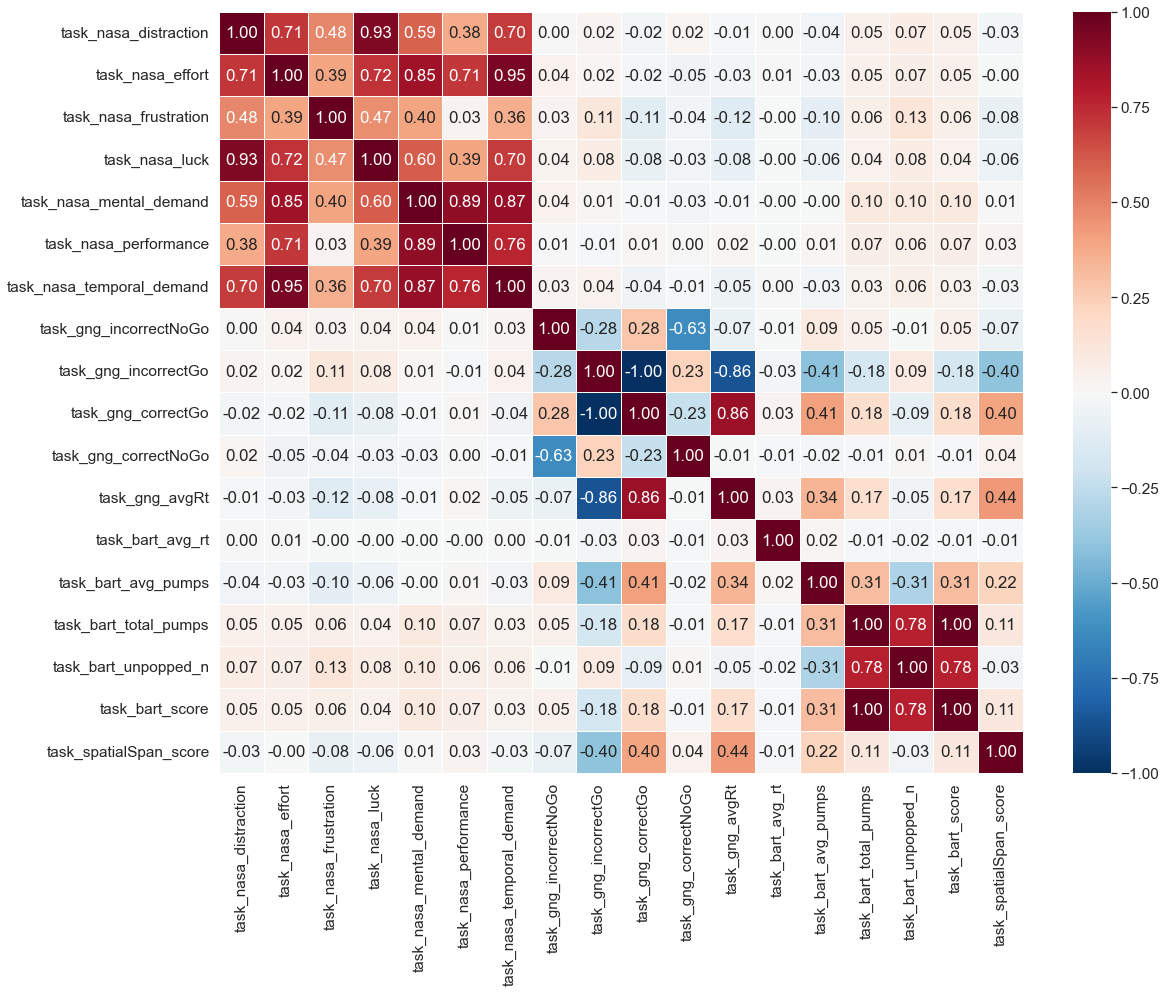

In [160]:
sns.set(rc={'figure.figsize':(18,14)})
sns.set(font_scale=1.4)

# select the tasks of interest
dfp = df[nasaTLX + gng + bart + spatialSpan]

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Largest Values

In [145]:
x = pd.DataFrame(dfp.corr().unstack().sort_values()).reset_index()

x.rename(columns={'level_0': 'affect1',
                  'level_1': 'affect2',
                  0: 'cor'
                  }, inplace=True)

In [146]:
# top -ve correlations
x.loc[x.cor < -.2].drop_duplicates(subset=['cor']).reset_index(drop=True)

,affect1,affect2,cor
0,task_gng_correctGo,task_gng_incorrectGo,-1.000000
1,task_gng_avgRt,task_gng_incorrectGo,-0.832016
2,task_gng_correctNoGo,task_gng_incorrectNoGo,-0.598276
3,task_gng_incorrectGo,task_spatialSpan_score,-0.365096
4,task_bart_unpopped_n,task_bart_avg_pumps,-0.335766
5,task_bart_avg_pumps,task_gng_incorrectGo,-0.330017
6,task_gng_incorrectNoGo,task_gng_incorrectGo,-0.288762
7,task_gng_correctGo,task_gng_correctNoGo,-0.207509


In [147]:
# top +ve correlations
x.loc[x.cor > .5].drop_duplicates(subset=['cor']).sort_values(by = 'cor', ascending=False).reset_index(drop=True)[1:11]

,affect1,affect2,cor
1,task_nasa_distraction,task_nasa_distraction,1.000000
2,task_nasa_effort,task_nasa_mental_demand,0.885900
3,task_nasa_effort,task_nasa_temporal_demand,0.880648
4,task_nasa_distraction,task_nasa_effort,0.852820
5,task_gng_correctGo,task_gng_avgRt,0.832016
6,task_nasa_temporal_demand,task_nasa_performance,0.831784
7,task_nasa_performance,task_nasa_mental_demand,0.824238
8,task_nasa_temporal_demand,task_nasa_mental_demand,0.813866
9,task_nasa_luck,task_nasa_temporal_demand,0.775919
10,task_nasa_distraction,task_nasa_temporal_demand,0.757527


#### Within Subject correlations

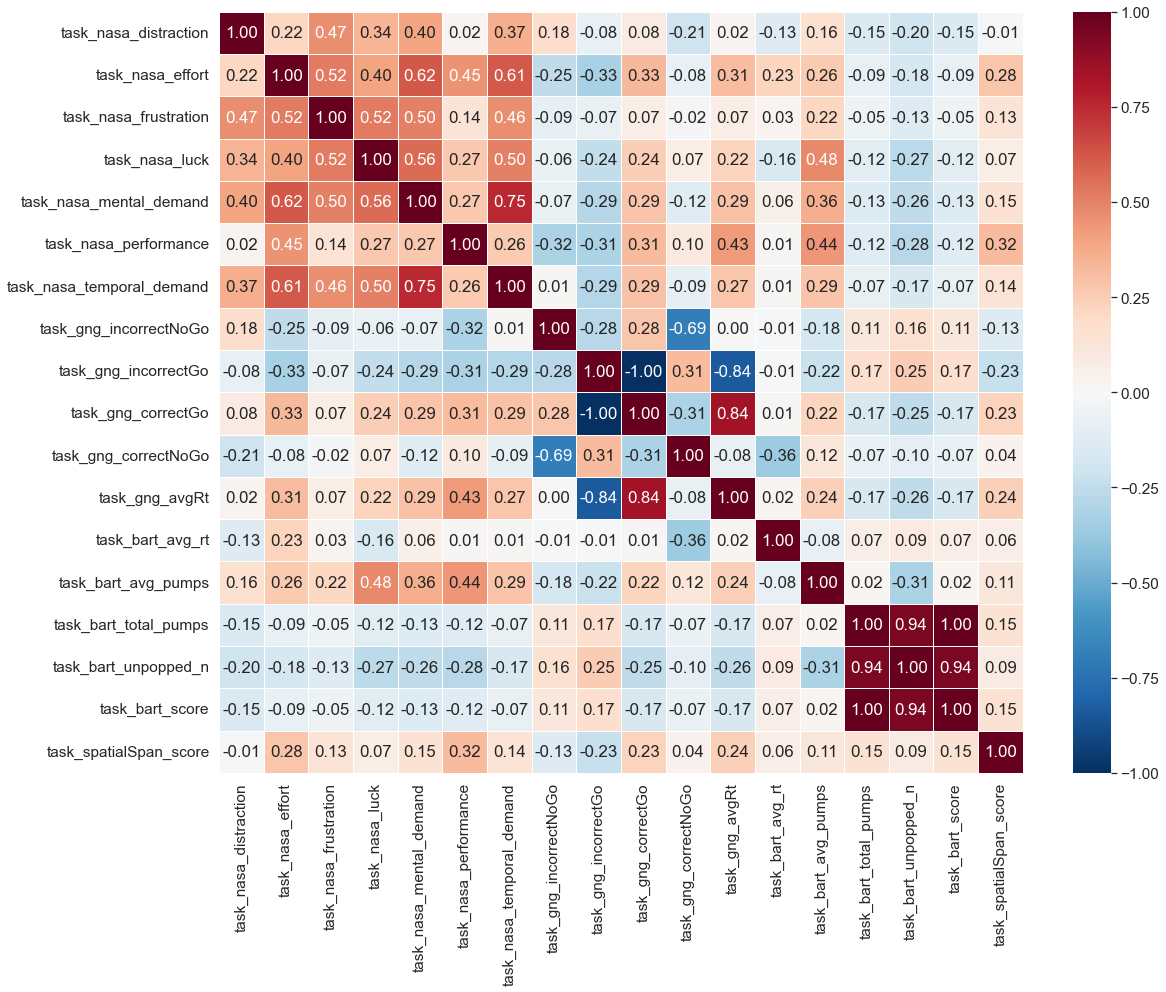

In [149]:
subs = np.unique(df_task.ParticipantIdentifier)
# select subject
# 5 very mixed
sub = 2 

x = df_task.loc[df_task.ParticipantIdentifier == subs[sub]]

dfp = x[nasaTLX + gng + bart + spatialSpan]

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

## Passive Data

This combines apple Health and sensorKit data

In [ ]:
df_passive = pd.read_csv(processed_data_path + 'run1_passive.csv')

In [ ]:
profile = ProfileReport(df_passive.drop(['trial_date', 'ParticipantIdentifier'], axis=1), 
                        title="Passive Measures: Profiling Report")
profile.to_file(processed_data_path + "run1_passive.html")

NameError: name 'ProfileReport' is not defined

# Combine All Data

In [12]:
df_battery = pd.read_csv(processed_data_path + 'run1_battery.csv')

In [13]:
df_qualtrics = pd.read_csv(processed_data_path + 'run1_qualtrics.csv')

In [8]:
df_affect = pd.read_csv(processed_data_path + 'run1_affect.csv')

In [10]:
df_sr = pd.read_csv(processed_data_path + 'run1_selfReport.csv')

In [11]:
df_task = pd.read_csv(processed_data_path + 'run1_tasks.csv')

In [ ]:
df_passive = pd.read_csv(processed_data_path + 'run1_passive.csv')

In [22]:
del(df)

In [23]:
df = pd.merge(df_affect, df_sr, how = 'outer', on = ['ParticipantIdentifier', 'trial_date'])
df = pd.merge(df, df_task, how = 'outer', on = ['ParticipantIdentifier', 'trial_date'])
#df = pd.merge(df, df_passive, how = 'outer', on = ['ParticipantIdentifier', 'trial_date'])
df = pd.merge(df, df_qualtrics, how = 'left', on = ['ParticipantIdentifier'])
df = pd.merge(df, df_battery, how = 'left', on = ['ParticipantIdentifier'])

In [24]:
df.shape

(4366, 4101)